## Prediction 

In [70]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [71]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage

In [72]:
data_dir = Path('data')
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [73]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [74]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [75]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [76]:
RETRAIN = True
RESIZE_IMAGES = False

In [100]:
img_size=256

In [81]:
def create_df(data_path, json, country, region):
    df = gpd.read_file(data_path/json)
    e=[country] * len(df)
    f=[region] * len(df)
    df['country'] = e
    df['region'] = f
    return df

In [83]:
df_list=[]
path_list= [colombia_rural, colombia_soacha, guatemala_mixco1, guatemala_mixco3,
         st_lucia_castries, st_lucia_dennery, st_lucia_gros_islet]
json_list=['train-borde_rural.geojson','train-borde_soacha.geojson','train-mixco_1_and_ebenezer.geojson','train-mixco_3.geojson',
          'train-castries.geojson','train-dennery.geojson','train-gros_islet.geojson']
country_list=['colombia','colombia','guatemala','guatemala','st_lucia','st_lucia','st_lucia']
region_list=['borde_rural','borde_soacha','mixco_1_and_ebenezer','mixco_3','castries','dennery','gros_islet']
for data_path, json, country, region in zip(path_list,json_list,country_list,region_list):
    df_list.append(create_df(data_path, json, country, region))

In [85]:
df_all = pd.concat(df_list)

In [87]:
df_all.tail()

,id,roof_material,verified,geometry,country,region
1962,7a22ddec,healthy_metal,False,"POLYGON ((-60.95293 14.08097, -60.95289 14.080...",st_lucia,gros_islet
1963,7a2f73ea,healthy_metal,False,"POLYGON ((-60.94701 14.08085, -60.94705 14.080...",st_lucia,gros_islet
1964,7a34ffa4,healthy_metal,False,"POLYGON ((-60.95235 14.08003, -60.95239 14.080...",st_lucia,gros_islet
1965,7a41560a,healthy_metal,False,"POLYGON ((-60.94875 14.08058, -60.94875 14.080...",st_lucia,gros_islet
1966,7a283ad0,healthy_metal,False,"POLYGON ((-60.94869 14.08074, -60.94869 14.080...",st_lucia,gros_islet


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [88]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

get average image size

In [89]:
import PIL.Image as pil_image
def img_type_av_sz(fn_list):
    widths = []
    heights = []
    for im in fn_list:
        #100 x faster than open_image(img_f)
        w,h=pil_image.open(im).size
        widths.append(w)
        heights.append(h)
    av_w = sum(widths)/len(widths)
    av_h = sum(heights)/len(heights)
    print(f'avg width: {av_w}, avg height: {av_h}, max w: {max(widths)}, min w: {min(widths)}, max h: {max(heights)}, min h: {min(heights)}')
    return widths, heights


In [90]:
fnames = get_image_files(path/'train')

In [91]:
fnames[0]

PosixPath('data/colombia_borde_rural/cropped/train/7a1e7446.tif')

In [92]:
test_fnames = get_image_files(path/'test')

In [93]:
widths, heights=img_type_av_sz(fnames)

avg width: 264.2011006649851, avg height: 266.640220132997, max w: 1502, min w: 69, max h: 1871, min h: 59


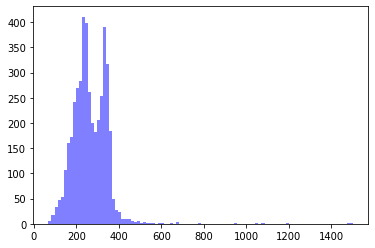

In [94]:
num_bins = 100
n, bins, patches = plt.hist(widths, num_bins, facecolor='blue', alpha=0.5)
plt.show()

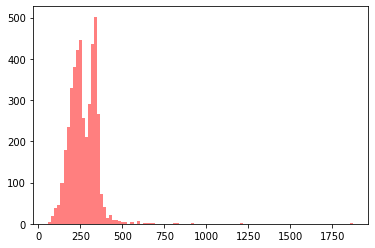

In [95]:
num_bins = 100
n, bins, patches = plt.hist(heights, num_bins, facecolor='red', alpha=0.5)
plt.show()

In [96]:
def resize_to_max(fn_list, max_w, max_h):
    widths = []
    heights = []
    for im in fn_list:
        with pil_image.open(im) as image:
            w,h=image.size
            if (w > max_w) or (h > max_h):
                res_im = resizeimage.resize_contain(image, [max_w, max_h])
                name=str(im).split('.')[0]
                res_im.save(f'{name}_512.tif', image.format)

In [97]:
def resize_all(fn_list, max_w, max_h, data_path, all_path):
    widths = []
    heights = []
    for im in fn_list:
        with pil_image.open(im) as image:
            w,h=image.size
            res_im = resizeimage.resize_contain(image, [max_w, max_h])
            name=str(im).split('.')[0]
            name=name.split('/')[-1]
            res_im.save(f'{data_path}/{name}.tif', image.format)
            shutil.copy(f'{data_path}/{name}.tif', all_path)

In [98]:
fnames[0]

PosixPath('data/colombia_borde_rural/cropped/train/7a1e7446.tif')

### resize all images

In [19]:
def resize_to(size=256):
    for c, r in zip(country_list, region_list):
        p=data_dir/f'{c}_{r}/cropped/'
        resize_all(fnames, size,size, data_path=f'{p}/train/{size}', all_path=data_dir/f'train/{size}')
        resize_all(test_fnames, size,size, data_path=f'{p}/test/{size}', all_path=data_dir/f'test/{size}')

In [ ]:
if RESIZE_IMAGES:
    resize_to(size=img_size)

### setup dataset

In [20]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=path/f'train/{img_size}', df=label_df, suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(path/'test/{img_size}'))

In [21]:
data = (src.transform(tfms, size=img_size)
        .databunch().normalize(imagenet_stats))

In [22]:
dir(data)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_grab_dataset',
 '_init_ds',
 '_square_show',
 'add_test',
 'add_tfm',
 'batch_size',
 'batch_stats',
 'create',
 'create_from_ll',
 'denorm',
 'device',
 'dl',
 'dl_tfms',
 'dls',
 'empty_val',
 'export',
 'fix_dl',
 'fix_ds',
 'from_csv',
 'from_df',
 'from_folder',
 'from_lists',
 'from_name_func',
 'from_name_re',
 'is_empty',
 'label_list',
 'load_empty',
 'loss_func',
 'norm',
 'normalize',
 'one_batch',
 'one_item',
 'path',
 'pre_transform',
 'presize',
 'remove_tfm',
 'sanity_check',
 'save',
 'show_batch',
 'single_dl',
 'single_ds',
 'single_from_classes',
 'stats',
 'test_dl',

In [23]:
data.label_list

LabelLists;

Train: LabelList (3489 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/colombia_borde_rural/cropped/train/256;

Valid: LabelList (872 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,healthy_metal,irregular_metal
Path: data/colombia_borde_rural/cropped/train/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/colombia_borde_rural/cropped/train/256

In [24]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

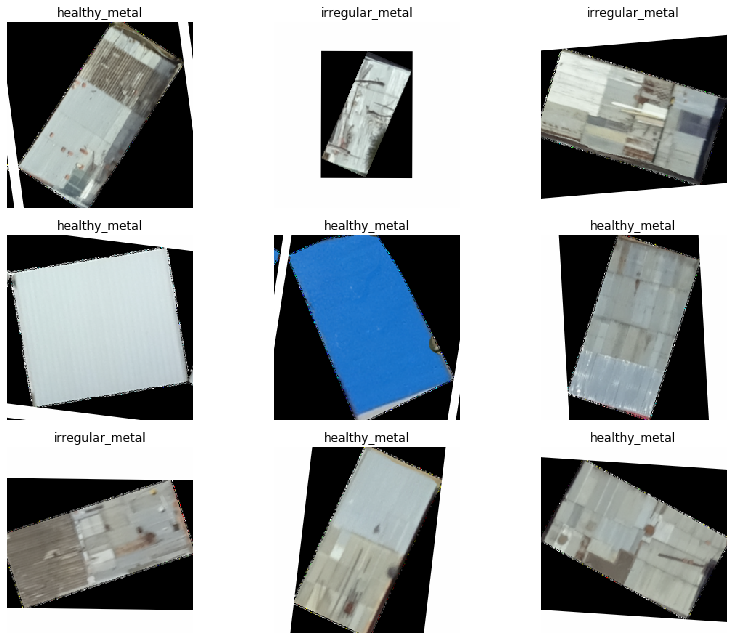

In [25]:
data.show_batch(rows=3, figsize=(12,9))

In [26]:
arch = models.resnet50

In [27]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True)

In [28]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

### (Re)train model

In [29]:
if RETRAIN:
    learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


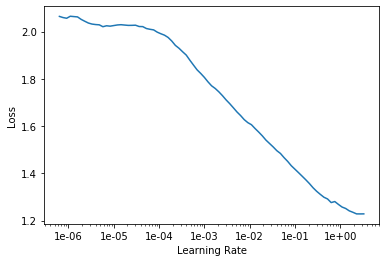

In [30]:
if RETRAIN:
    learn.recorder.plot()

Then we can fit the head of our network.

In [31]:
if RETRAIN:
    lr = 1e-1

In [32]:
if RETRAIN:
    learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.864441,1.004792,0.235092,00:15
1,0.658296,0.691007,0.225917,00:15
2,0.569482,0.574670,0.208716,00:14
3,0.509644,0.481442,0.175459,00:15
4,0.475893,0.441095,0.159404,00:15


In [33]:
if RETRAIN:
    learn.save('stage-1-rn50')
    #saves in parent of models directory
    learn.export()

#### Load model

In [34]:
if RETRAIN:
    learn.load('stage-1-rn50')

### inference

In [35]:
test=ImageList.from_folder(path/'test/256')

In [36]:
learn = load_learner(path/'train/256', test=test)

In [37]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [38]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [39]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

Get number of items in the Valid dataset (in DeviceDataLoader)

In [40]:
len(learn.dl(DatasetType.Test).dl)

69

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [41]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [42]:
labels = np.argmax(preds, 1)

In [43]:
len(preds)

4361

In [44]:
preds[0].tolist()

[0.002688748762011528,
 0.9220978617668152,
 0.0020721890032291412,
 0.06999193131923676,
 0.0031493573915213346]

In [45]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [46]:
len(labels)

4361

In [47]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [48]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [49]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [50]:
test_predictions[0]

'healthy_metal'

In [51]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [52]:
 learn.data.test_ds.x.items

array([PosixPath('data/colombia_borde_rural/cropped/test/256/7a1e7446.tif'),
       PosixPath('data/colombia_borde_rural/cropped/test/256/7a1ef3a8.tif'),
       PosixPath('data/colombia_borde_rural/cropped/test/256/7a428ae8.tif'),
       PosixPath('data/colombia_borde_rural/cropped/test/256/7a43070c.tif'), ...,
       PosixPath('data/colombia_borde_rural/cropped/test/256/7a3420de.tif'),
       PosixPath('data/colombia_borde_rural/cropped/test/256/7a2b5c1a.tif'),
       PosixPath('data/colombia_borde_rural/cropped/test/256/7a447a4c.tif'),
       PosixPath('data/colombia_borde_rural/cropped/test/256/7a345e14.tif')], dtype=object)

In [53]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [54]:
preds_list[0]

[0.002688748762011528,
 0.9220978617668152,
 0.0020721890032291412,
 0.06999193131923676,
 0.0031493573915213346]

In [55]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [56]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [57]:
df.head()

,id,pred
0,7a1e7446,"[0.002688748762011528, 0.9220978617668152, 0.0..."
1,7a1ef3a8,"[0.0018592769047245383, 0.00014713301789015532..."
2,7a428ae8,"[0.0027281877119094133, 0.9758926033973694, 0...."
3,7a43070c,"[0.014673776924610138, 0.36774942278862, 0.008..."
4,7a302b78,"[0.0020765424706041813, 0.05246352031826973, 0..."


In [58]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [59]:
pred_df.insert(loc=0, column='id', value=ids)

In [60]:
pred_df.columns = cols

In [61]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a1e7446,0.002689,0.922098,0.002072,0.069992,0.003149
1,7a1ef3a8,0.001859,0.000147,0.993662,0.003973,0.000359
2,7a428ae8,0.002728,0.975893,0.002579,0.015005,0.003795
3,7a43070c,0.014674,0.367749,0.008945,0.604382,0.004250
4,7a302b78,0.002077,0.052464,0.056013,0.886408,0.003039


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


### Re-train

In [56]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


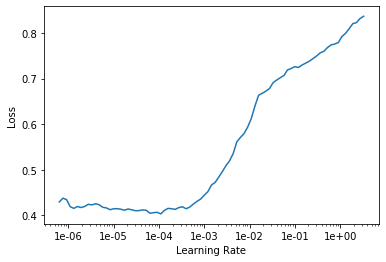

In [57]:
learn.lr_find()
learn.recorder.plot()

In [58]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.450725,0.815048,0.264908,00:20
1,0.471160,0.515863,0.181193,00:20
2,0.460313,0.463840,0.167431,00:20
3,0.437917,0.448464,0.170872,00:20
4,0.402474,0.441463,0.168578,00:20


In [59]:
learn.save('stage-2-rn50')

In [20]:
learn.load('stage-2-rn50')

FileNotFoundError: [Errno 2] No such file or directory: 'data/colombia_borde_rural/cropped/train/256/models/stage-2-rn50.pth'

In [60]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [61]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


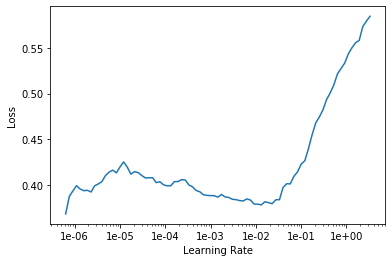

In [62]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=1e-2/2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.087761,0.085013,0.958006,0.926066
2,0.087641,0.083732,0.958260,0.927459
3,0.084250,0.082856,0.958485,0.928200
4,0.082347,0.081470,0.960091,0.929166
5,0.078463,0.080984,0.959249,0.930089


In [ ]:
learn.save('stage-1-256-rn50')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.082938,0.083548,0.957846,0.927756
2,0.086312,0.084802,0.958718,0.925416
3,0.084824,0.082339,0.959975,0.930054
4,0.078784,0.081425,0.959983,0.929634
5,0.074530,0.080791,0.960426,0.931257


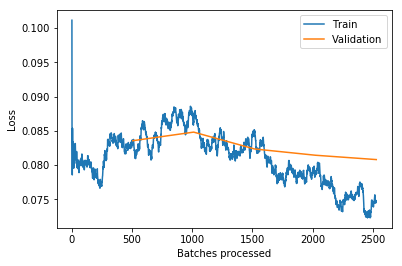

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [ ]:
learn.export()